<a href="https://colab.research.google.com/github/christian7777777777/Introduccion-a-la-vision-artificial/blob/main/Fine_Tunning_con_Faster_Rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar Dependencias

In [ ]:
!pip install torch torchvision
!pip install opencv-python
!pip install matplotlib
!pip install pillow
!pip install pycocotools  # Para métricas de evaluación
!pip install albumentations  # Para aumentación de datos

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

# Descomprimir Dataset "Guns"

In [ ]:
!unzip /content/GunSurveilenceV2.v1i.coco.zip -d /content/dataset

Archive:  /content/GunSurveilenceV2.v1i.coco.zip
 extracting: /content/dataset/README.dataset.txt  
 extracting: /content/dataset/README.roboflow.txt  
   creating: /content/dataset/test/
 extracting: /content/dataset/test/_annotations.coco.json  
 extracting: /content/dataset/test/armas-35-_jpg.rf.8eb2354116263a99c330412c3be2be79.jpg  
 extracting: /content/dataset/test/armas-36-_jpg.rf.e433d7cdc57001b92e4d5444b7e6559a.jpg  
 extracting: /content/dataset/test/armas-38-_jpg.rf.2111a30164107b38e7522b8346665084.jpg  
 extracting: /content/dataset/test/armas-39-_jpg.rf.fd3a2a6972567b80e65746cd3231f02e.jpg  
 extracting: /content/dataset/test/armas-397-_jpg.rf.1d12e04b9ee99a84c5973121aa866f6e.jpg  
 extracting: /content/dataset/test/armas-400-_jpg.rf.710c8e47cfeec4d5ebc0a980de35ba0c.jpg  
 extracting: /content/dataset/test/armas-403-_jpg.rf.4f1bf05c863e3d9e2abf7ccccdce37e9.jpg  
 extracting: /content/dataset/test/armas-41-_jpg.rf.28b55cdc2d51145ccfefa44e87ad783e.jpg  
 extracting: /content

# Importar Librerias

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import time
from google.colab import drive
import cv2
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob
from tqdm.notebook import tqdm
from pycocotools.coco import COCO

*Esta celda es **crucial** para la reproducibilidad de los experimentos de entrenamiento. Al establecer una semilla para los generadores de **números aleatorios**, se asegura que los resultados sean consistentes en diferentes ejecuciones del código, lo que facilita la depuración, la comparación de modelos y la validación de los resultados.*

In [ ]:
# Semilla para reproducibilidad
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

# Verificacion de GPU

In [ ]:
# Comprobar si hay GPU disponible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Utilizando: {device}")


Utilizando: cuda


# Preprocesameinto del Dataset personalizado

In [ ]:
# Clase para el dataset personalizado
class CocoDataset(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

        # Filtrar imágenes sin anotaciones
        ids_with_ann = []
        for img_id in self.ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            if len(ann_ids) > 0:
                ids_with_ann.append(img_id)
        self.ids = ids_with_ann

        # Mapear categorías COCO a índices continuos
        self.categories = {cat['id']: i + 1 for i, cat in enumerate(self.coco.loadCats(self.coco.getCatIds()))}

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        # Cargar imagen
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert('RGB')

        # Preparar las cajas delimitadoras y etiquetas
        boxes = []
        labels = []
        areas = []

        for ann in annotations:
            # Cajas en formato COCO: [x, y, width, height]
            # Convertir a formato PyTorch: [x_min, y_min, x_max, y_max]
            x, y, width, height = ann['bbox']
            xmin = x
            ymin = y
            xmax = x + width
            ymax = y + height

            # Asegurarse de que las cajas tienen área positiva
            if width > 0 and height > 0:
                boxes.append([xmin, ymin, xmax, ymax])
                # Mapear ID de categoría a índice continuo
                labels.append(self.categories[ann['category_id']])
                areas.append(width * height)

        # Convertir a tensores
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)

        # Otras informaciones necesarias
        image_id = torch.tensor([img_id])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # Crear diccionario de target
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)

    def get_num_classes(self):
        return len(self.categories) + 1  # +1 para la clase background

# Cargar el modelo Faster R-CNN pre entrenado y realizar Transfer Learning

In [ ]:
# Función para obtener el modelo Faster R-CNN pre-entrenado y ajustar el número de clases
def get_model(num_classes):
    # Cargar modelo pre-entrenado en COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Obtener el número de características de entrada del clasificador
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Reemplazar el clasificador por uno nuevo con el número de clases correspondiente
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Configurar rutas del dataset

In [ ]:
# Configuración del dataset
# Ruta al dataset descomprimido
DATASET_PATH = '/content/dataset'

# Rutas para train y validation (pueden variar según la estructura de Roboflow)
TRAIN_JSON = os.path.join(DATASET_PATH, 'train', '_annotations.coco.json')
TRAIN_IMAGES = os.path.join(DATASET_PATH, 'train')

VAL_JSON = os.path.join(DATASET_PATH, 'valid', '_annotations.coco.json')
VAL_IMAGES = os.path.join(DATASET_PATH, 'valid')

# Configurar los Dataloaders

In [ ]:

# Define las transformaciones
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class RandomHorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)

            # También hay que voltear las cajas
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox

        return image, target

# Transformaciones
train_transforms = Compose([
    ToTensor(),
    RandomHorizontalFlip(0.5)
])

val_transforms = Compose([
    ToTensor()
])

# Crear datasets
dataset_train = CocoDataset(TRAIN_IMAGES, TRAIN_JSON, transforms=train_transforms)
dataset_val = CocoDataset(VAL_IMAGES, VAL_JSON, transforms=val_transforms)

# Obtener número de clases
num_classes = dataset_train.get_num_classes()

# Collate function para el DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

# Crear dataloaders
data_loader_train = DataLoader(
    dataset_train, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=2
)
data_loader_val = DataLoader(
    dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=2
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Generar el modelo e hiperparametros

In [ ]:
# Obtener modelo
model = get_model(num_classes)
model.to(device)

# Definir optimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Definir learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Número de épocas
num_epochs = 5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 162MB/s]


# Definir la funcion de entrenamiento

In [ ]:
# Función de entrenamiento
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()

    all_losses = []
    for images, targets in tqdm(data_loader, desc=f"Epoch {epoch}"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        all_losses.append(losses.item())

    return np.mean(all_losses)


# Definir la funcion de evaluacion

In [ ]:
# Función de evaluación corregida
def evaluate(model, data_loader, device):
    model.eval()

    all_losses = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Validación"):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # En modo evaluación, necesitamos forzar el cálculo de pérdidas
            loss_dict = model(images, targets)

            # Verificar si es una lista (modo predicción) o un diccionario (modo pérdida)
            if isinstance(loss_dict, list):
                # Estamos en modo predicción, necesitamos calcular las pérdidas manualmente
                # Para esto, necesitamos volver a llamar al modelo con el flag de entrenamiento
                model.train()
                loss_dict = model(images, targets)
                model.eval()  # Volver a modo evaluación

            losses = sum(loss for loss in loss_dict.values())
            all_losses.append(losses.item())

    return np.mean(all_losses)

# Definir funcion para visualizacion

In [ ]:
# Función para visualizar resultados
def visualize_predictions(model, dataset, idx=0, threshold=0.7):
    model.eval()
    img, _ = dataset[idx]

    with torch.no_grad():
        prediction = model([img.to(device)])

    img = img.permute(1, 2, 0).cpu().numpy()

    # Normalizar imagen para visualización
    img = (img * 255).astype(np.uint8)
    img_pil = Image.fromarray(img)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    boxes = prediction[0]['boxes'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    # Filtrar predicciones por umbral de confianza
    keep = scores > threshold
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]

    # Dibujar las cajas
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x1, y1, f"Class: {label-1}, {score:.2f}", bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    plt.show()


# Entrenar el modelo

In [ ]:
# Historial de pérdidas
train_losses = []
val_losses = []

# Bucle de entrenamiento
print("Iniciando entrenamiento...")
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, data_loader_train, device, epoch)
    train_losses.append(train_loss)

    # Evaluación
    val_loss = evaluate(model, data_loader_val, device)
    val_losses.append(val_loss)

    # Actualizar learning rate
    lr_scheduler.step()

    print(f"Época {epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Guardar modelo cada 5 épocas
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f'fasterrcnn_custom_epoch_{epoch}.pth')


Iniciando entrenamiento...


Epoch 0:   0%|          | 0/210 [00:00<?, ?it/s]

Validación:   0%|          | 0/20 [00:00<?, ?it/s]

Época 0 - Train Loss: 0.2013, Val Loss: 0.1763


Epoch 1:   0%|          | 0/210 [00:00<?, ?it/s]

Validación:   0%|          | 0/20 [00:00<?, ?it/s]

Época 1 - Train Loss: 0.1163, Val Loss: 0.1337


Epoch 2:   0%|          | 0/210 [00:00<?, ?it/s]

Validación:   0%|          | 0/20 [00:00<?, ?it/s]

Época 2 - Train Loss: 0.0804, Val Loss: 0.1332


Epoch 3:   0%|          | 0/210 [00:00<?, ?it/s]

Validación:   0%|          | 0/20 [00:00<?, ?it/s]

Época 3 - Train Loss: 0.0584, Val Loss: 0.1279


Epoch 4:   0%|          | 0/210 [00:00<?, ?it/s]

Validación:   0%|          | 0/20 [00:00<?, ?it/s]

Época 4 - Train Loss: 0.0491, Val Loss: 0.1359


# Guardar el modelo entrenado

In [ ]:
# Guardar modelo final
torch.save(model.state_dict(), 'fasterrcnn_custom_final.pth')

# Graficas de entrenamiento

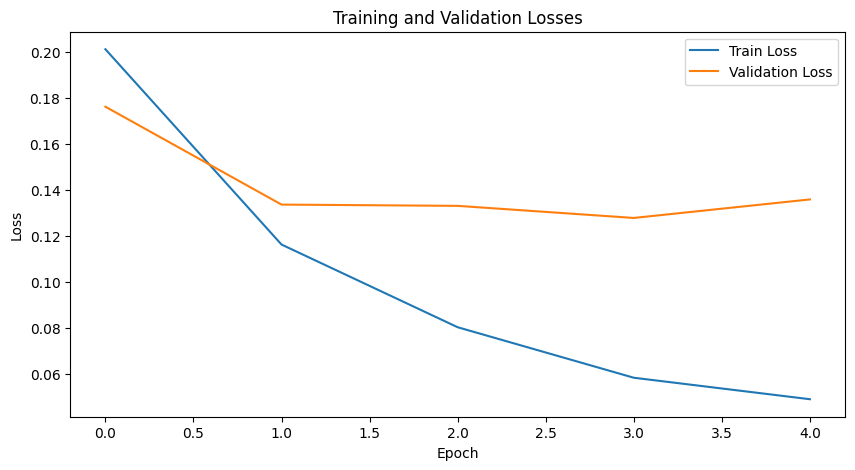

In [ ]:
# Visualizar gráfica de pérdidas
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

# Inferencia en dataset de Testeo

Visualizando predicciones en el conjunto de validación:


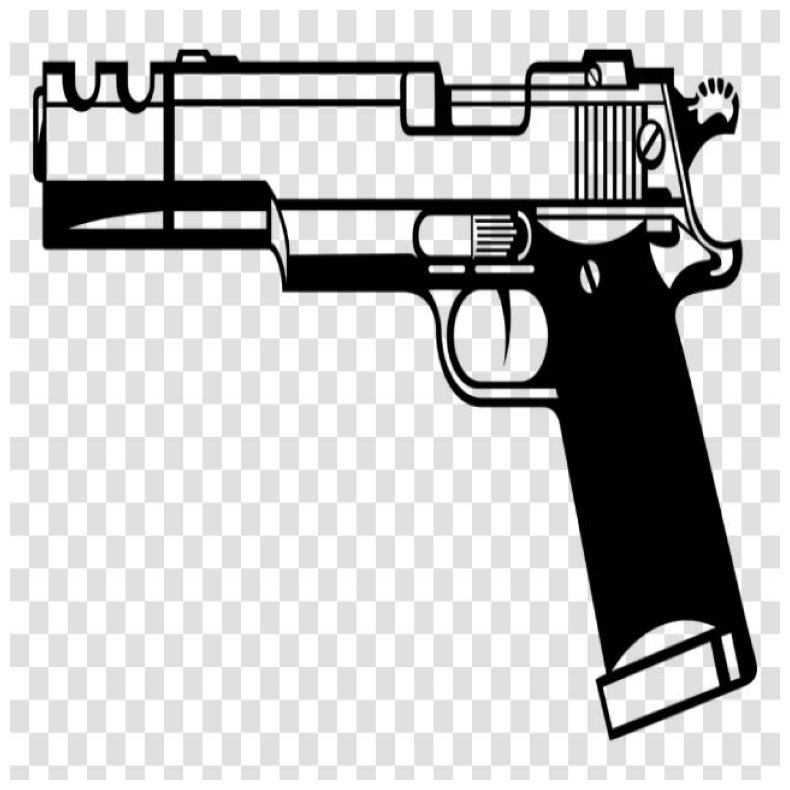

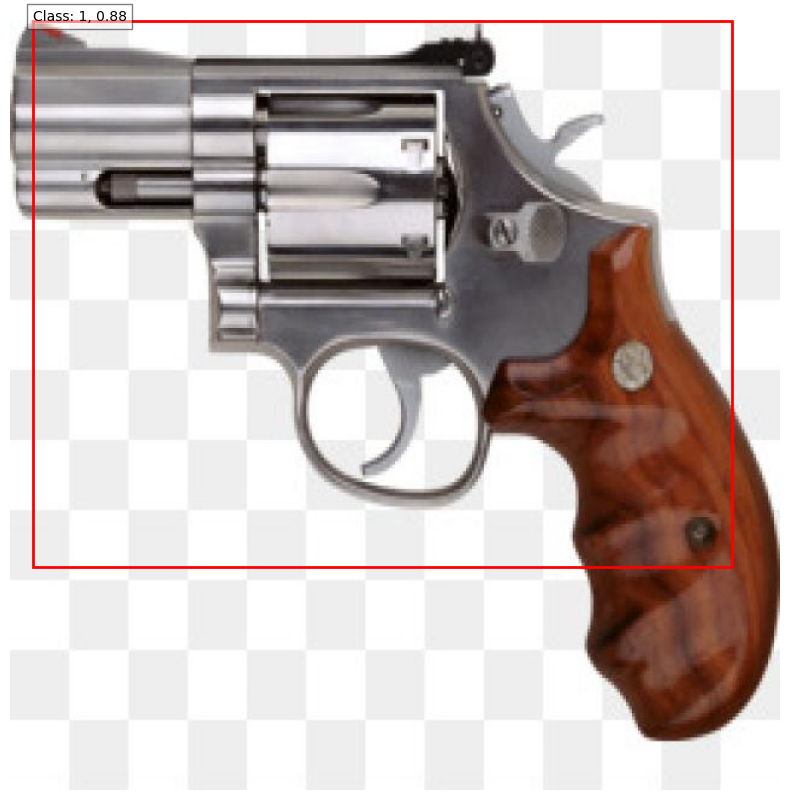

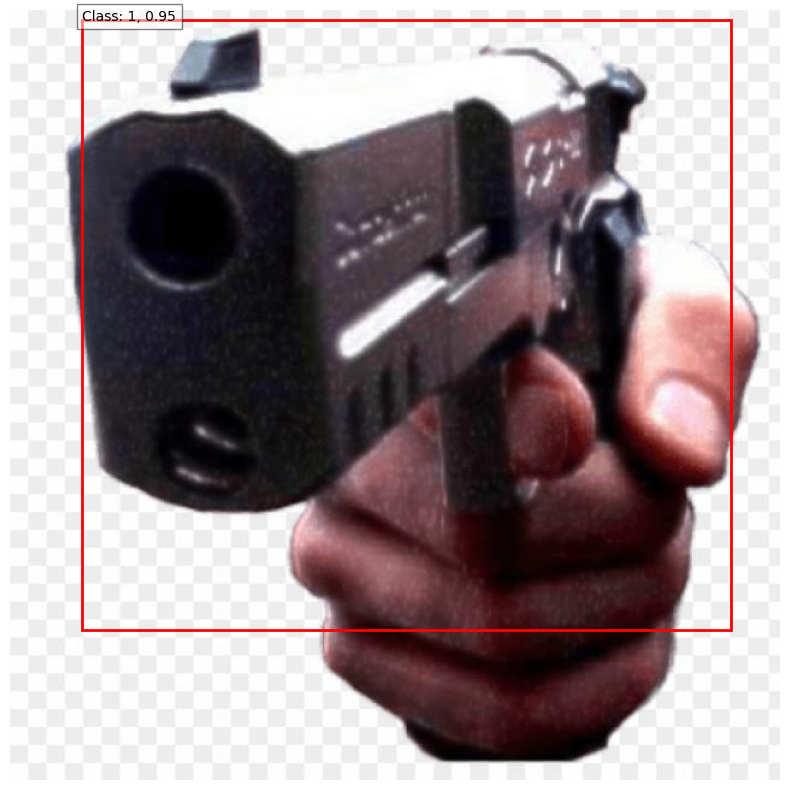

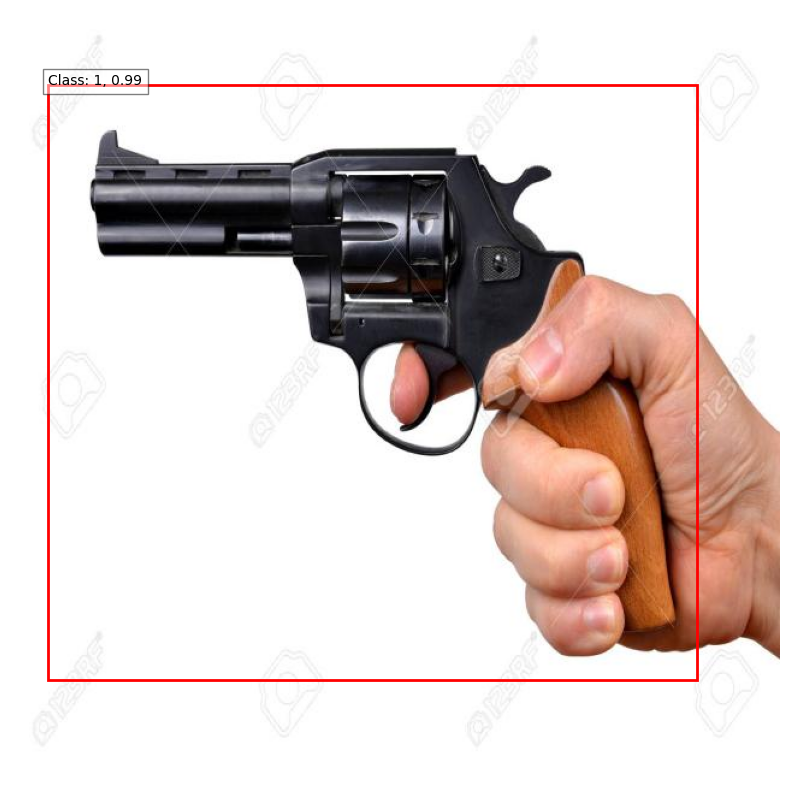

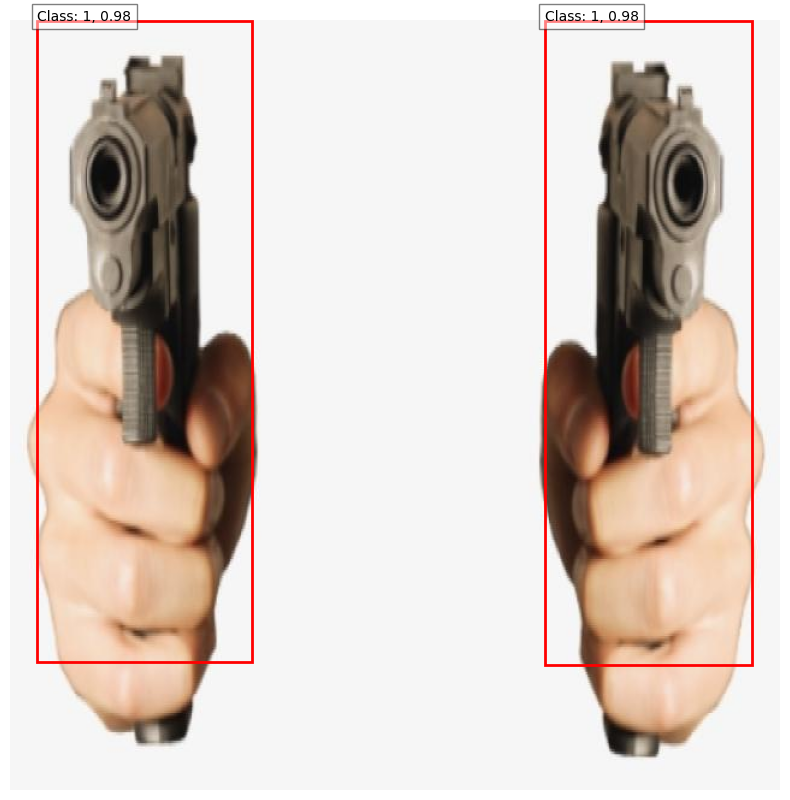

In [ ]:
# Visualizar algunas predicciones
print("Visualizando predicciones en el conjunto de validación:")
for i in range(min(5, len(dataset_val))):
    visualize_predictions(model, dataset_val, idx=i)

# Funcion para inferencia en imagen

In [ ]:
# Función para realizar inferencia en una nueva imagen
def inference_on_image(model, image_path, threshold=0.7):
    model.eval()

    # Cargar y transformar la imagen
    img = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img)

    with torch.no_grad():
        prediction = model([img_tensor.to(device)])

    # Extraer resultados
    boxes = prediction[0]['boxes'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    # Filtrar por umbral de confianza
    keep = scores > threshold
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]

    # Convertir a imagen numpy para visualización
    img_np = np.array(img)

    # Dibujar resultados
    plt.figure(figsize=(12, 12))
    plt.imshow(img_np)

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box.astype(int)
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x1, y1, f"Class: {label-1}, {score:.2f}", bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    plt.title(f"Detections on {os.path.basename(image_path)}")
    plt.show()

    return boxes, labels, scores

**Cargar imagen de prueba y realizar prediccion**

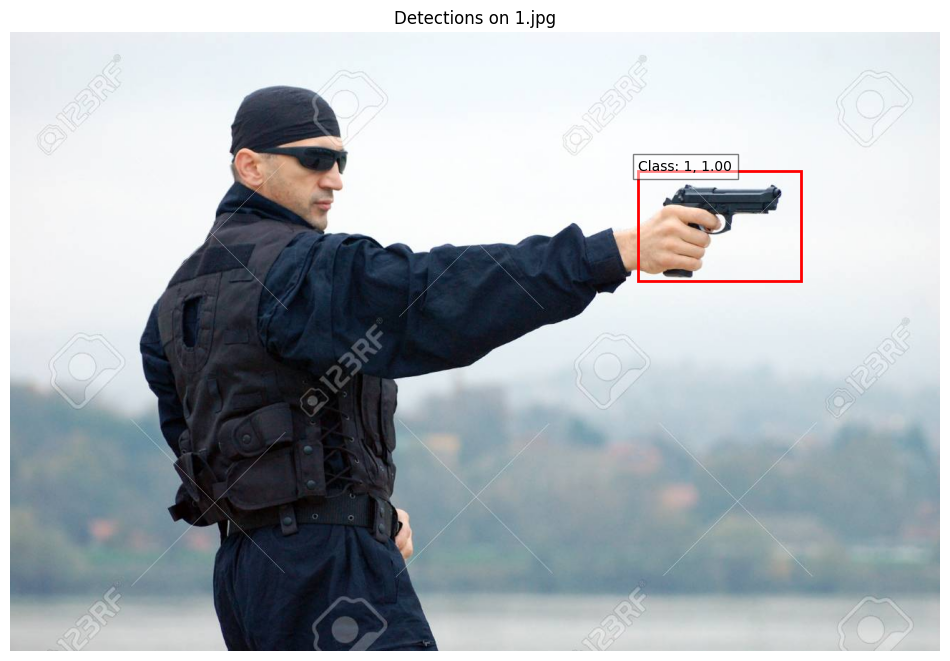

(array([[ 878.9076 ,  193.99118, 1105.6555 ,  347.52673]], dtype=float32),
 array([2]),
 array([0.9953312], dtype=float32))

In [ ]:
# Inferencia en imagen de prueba (descomenta para usar)
imagen_prueba = "/content/1.jpg"
inference_on_image(model, imagen_prueba)

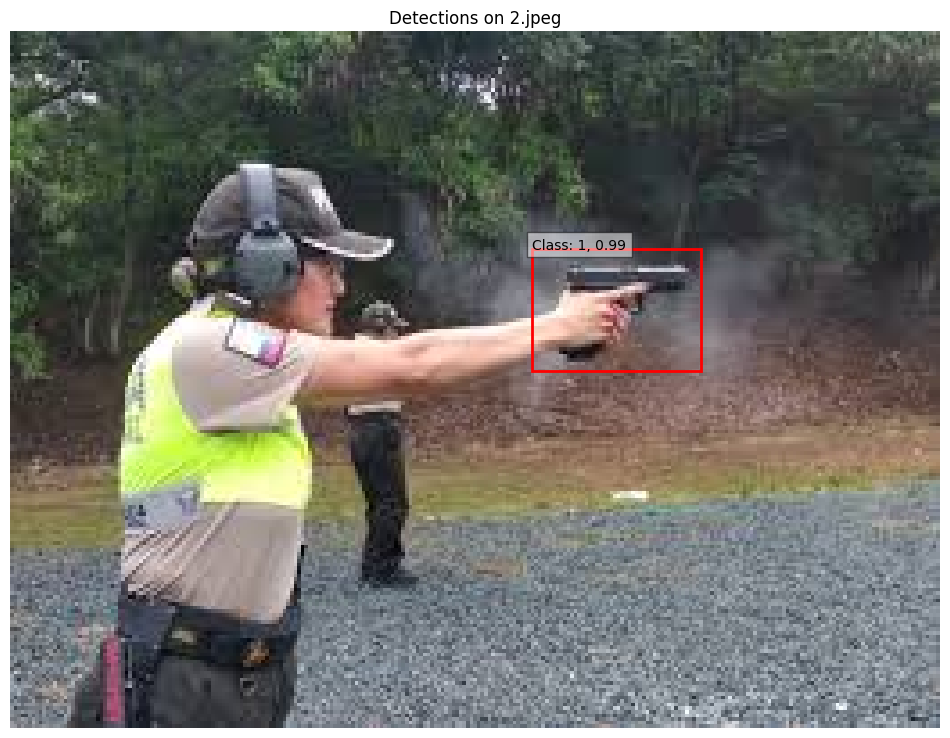

(array([[145.92656 ,  60.039127, 192.96278 ,  94.5473  ]], dtype=float32),
 array([2]),
 array([0.99212474], dtype=float32))

In [ ]:
# Inferencia en imagen de prueba (descomenta para usar)
imagen_prueba = "/content/2.jpeg"
inference_on_image(model, imagen_prueba)